In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import pickle
import dask.dataframe as dd
import seaborn as sns
import numpy as np

from sklearn.metrics import r2_score

In [2]:
with open('../leave_1_out/splits_samples.pkl', 'rb') as file:
    splits_samples = pickle.load(file)

train_samples = splits_samples[0][0]
test_samples = splits_samples[0][1]

## import deltap ld for testing because not ldp will take forever 
delta_ldp = pd.read_csv('/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_hapFIRE_delta_p_LDpruned.txt', 
                        sep = '\t', 
                        usecols = train_samples)

clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')

sites = pd.Series(train_samples).str.split('_').str[0].astype(int)

env = sites.reset_index().merge(clim_sites_during_exp, right_on = 'site', left_on = 0).drop(['index'],axis=1)
env = env.drop(0,axis=1)
mean_env = env['bio1'].mean()
std_env = env['bio1'].std()

env['bio1'] = (env['bio1'] - mean_env) / std_env

# Load data
#data = pd.read_csv('data.csv')

# Define the features and targets
X_train = np.array(env.drop('site',axis=1).copy()['bio1']).reshape(-1, 1)#.reset_index()  # n_env_vars is the number of environmental variables
#X_train = env.drop('site',axis=1).copy()
y_train_full = delta_ldp.T.copy()

sites_test = pd.Series(test_samples).str.split('_').str[0].astype(int)

env_test = sites_test.reset_index().merge(clim_sites_during_exp, right_on = 'site', left_on = 0).drop(['index'],axis=1)
env_test = env_test.drop(0,axis=1)
#X_test = env_test.drop('site',axis=1).copy()

env_test['bio1'] = (env_test['bio1'] - mean_env) / std_env

X_test = np.array(env_test.drop('site',axis=1).copy()['bio1']).reshape(-1, 1)

## import deltap ld for testing because not ldp will take forever 
delta_ldp_test = pd.read_csv('/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_hapFIRE_delta_p_LDpruned.txt', 
                        sep = '\t', 
                        usecols = test_samples)

y_test_full = delta_ldp_test.T.copy()

In [2]:
model_results = pd.read_csv('model_results.txt')

In [3]:
model_results

,SNP,Best Parameters,R2 Score Train,R2 Score Test
0,max_depth: 2,n_estimators: 100,0.000576,0.405351
1,max_depth: 2,n_estimators: 100,0.149103,0.171199
2,max_depth: 2,n_estimators: 300,0.587259,0.761728
3,max_depth: 2,n_estimators: 200,0.016688,0.190994
4,max_depth: 2,n_estimators: 300,0.067823,0.019091
...,...,...,...,...
13980,max_depth: 2,n_estimators: 200,0.522540,0.874385
13981,max_depth: 3,n_estimators: 100,0.025248,0.541803
13982,max_depth: 2,n_estimators: 200,0.016329,0.464889
13983,max_depth: 2,n_estimators: 100,0.272542,0.026697


In [14]:
model_results['depth'] = model_results['SNP'].str.split(': ').str[1]

In [18]:
model_results['depth'] = model_results['depth'].replace('None', np.nan).astype(float)

In [19]:
model_results['nest'] = model_results['Best Parameters'].str.split(': ').str[1].astype(int)

In [20]:
model_results['depth'].unique()

array([ 2., nan,  3., 10.,  5., 20.])

In [21]:
model_results['depth'].value_counts()

depth
2.0     14247
3.0      2456
5.0       425
10.0      203
20.0       87
Name: count, dtype: int64

In [22]:
model_results['nest'].value_counts()

nest
300    6145
100    5742
200    5600
Name: count, dtype: int64

In [23]:
model_results[model_results['depth'] == 'None']

,SNP,Best Parameters,R2 Score Train,R2 Score Test,depth,nest


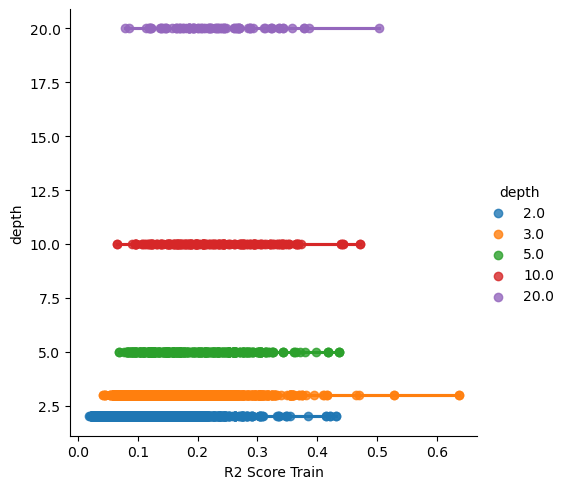

In [24]:
sns.lmplot(model_results, x = 'R2 Score Train', y = 'depth' , hue = 'depth')

<Axes: xlabel='R2 Score Train', ylabel='R2 Score Test'>

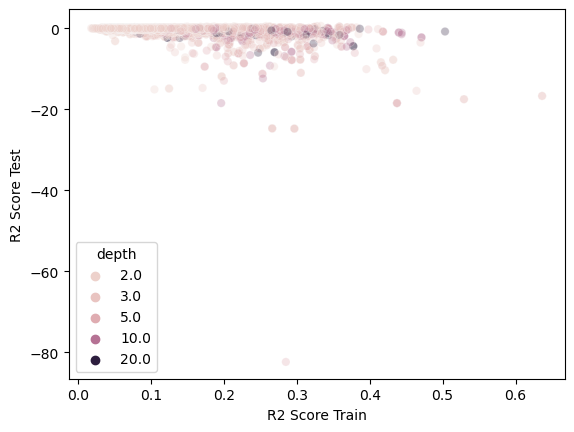

In [25]:
sns.scatterplot(model_results, x = 'R2 Score Train', y = 'R2 Score Test' , hue = 'depth',alpha = 0.3)

In [26]:
model_results = model_results[model_results['R2 Score Test'] > 0]

<Axes: xlabel='depth', ylabel='R2 Score Test'>

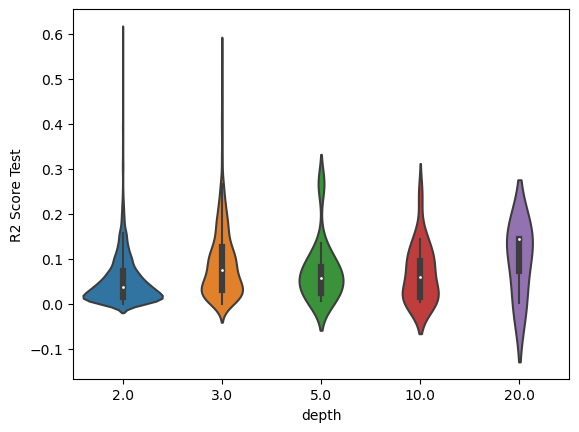

In [27]:
sns.violinplot(model_results, x = 'depth', y = 'R2 Score Test' )

<Axes: xlabel='nest', ylabel='R2 Score Test'>

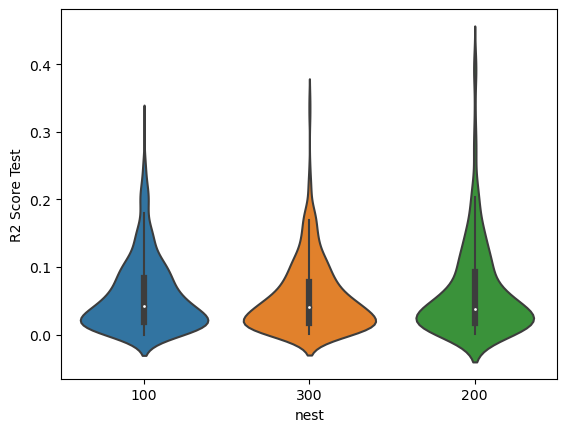

In [24]:
sns.violinplot(model_results, x = 'nest', y = 'R2 Score Test' )

In [ ]:
sns.violinplot(model_results, x = 'depth', y = 'R2 Score Test' )

In [26]:
model_results.groupby('nest')['R2 Score Test'].median()

nest
100    0.041932
200    0.038467
300    0.040324
Name: R2 Score Test, dtype: float64

In [18]:
model_results.groupby('depth')['R2 Score Test'].mean()

depth
10      0.058817
2       0.053599
3       0.089140
5       0.070479
None    0.110127
Name: R2 Score Test, dtype: float64

In [12]:
r2_scores_train_all = []
r2_scores_test_all = []
for i in y_train_full.columns:
    y_train = y_train_full[i]
    # Create a random forest regressor object
    forest = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Train the model
    forest.fit(X_train, y_train)
    ## evalaute on the training 
    y_predict_train = forest.predict(X_train)
    r2_scores_train = r2_score(y_train, y_predict_train, multioutput='raw_values')
    r2_scores_train_all.append(r2_scores_train)
    ##evaluate on the testing 
    y_test = y_test_full[i]
    y_predict_test = forest.predict(X_test)
    r2_scores_test = r2_score(y_test, y_predict_test, multioutput='raw_values')
    r2_scores_test_all.append(r2_scores_test)
    print(r2_scores_test)

[0.00377857]
[0.13329187]
[-0.16030297]
[-0.26167071]
[-0.36972713]
[-0.07421298]
[-0.01514192]
[-0.20898591]
[0.06426335]
[-0.12322189]
[0.01910032]
[-0.11662627]
[-0.21533329]
[-0.09708754]
[0.0861716]
[-0.09159923]
[-0.33708502]
[0.16177826]
[-0.54641617]
[-0.90802349]
[-0.22777768]
[0.03352733]
[0.03712493]
[0.10926764]
[-0.23373455]
[0.25107685]
[0.01444232]
[-0.06550663]
[0.03551885]
[-0.02684924]
[-0.11852108]
[-0.15015615]
[-0.09788779]
[-0.0310877]
[-0.44744946]
[-0.19008998]
[0.05765637]
[0.04887208]
[-0.14260869]
[-0.21683307]
[-0.20633282]
[0.02329572]
[-0.24387703]
[-0.0403401]
[-0.52328584]
[0.14942188]
[-0.20749711]
[-0.10220301]
[-0.21250979]
[0.0276389]
[-0.05379834]
[-0.06994653]
[-0.29589371]
[-0.17513675]
[0.05996433]
[0.00868156]
[0.04619908]
[-0.22263794]
[0.13309357]
[-0.21385542]
[-0.18908652]
[-0.01869784]
[0.06589787]
[0.08554006]
[-0.12175335]
[0.08284508]
[-0.04230793]
[-0.07301937]
[0.04810796]
[-0.0219426]
[-0.18064001]
[0.14961561]
[-0.01057569]
[-0.06859

In [17]:
r2_scores_train_all = pd.Series(np.array(r2_scores_train_all).flatten())

<Axes: ylabel='Count'>

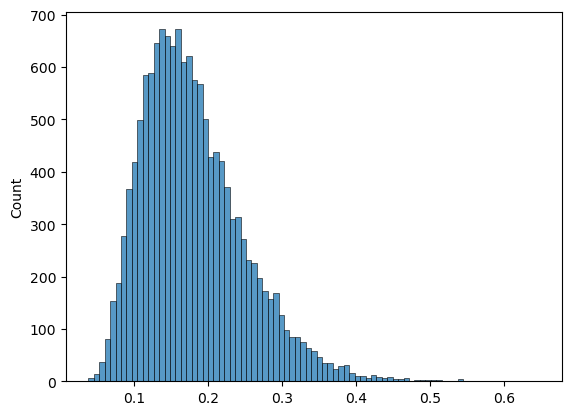

In [18]:
sns.histplot(r2_scores_train_all)

In [19]:
r2_scores_test_all = pd.Series(np.array(r2_scores_test_all).flatten())

In [22]:
r2_scores_test_all.describe()

count    13985.000000
mean        -0.077929
std          0.234907
min        -10.438566
25%         -0.120303
50%         -0.046449
75%          0.012884
max          0.387816
dtype: float64

<Axes: ylabel='Count'>

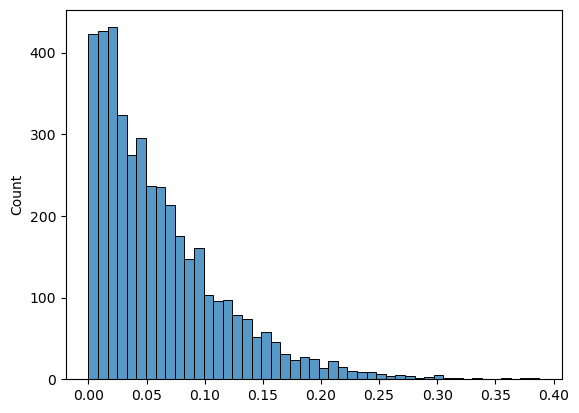

In [21]:
sns.histplot(r2_scores_test_all[r2_scores_test_all>0])

<Axes: >

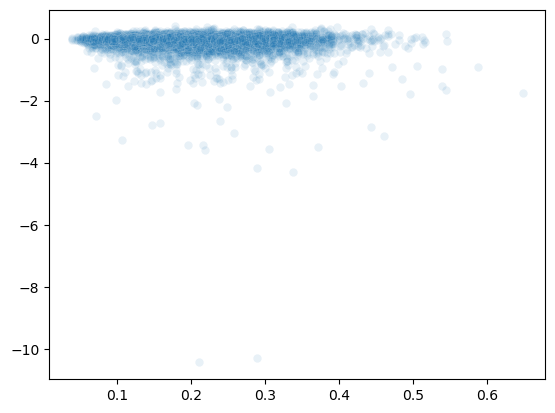

In [26]:
sns.scatterplot(x = r2_scores_train_all, y = r2_scores_test_all, alpha = 0.1)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    #'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 2, 3, 5, 10, 20],   # Maximum number of levels in tree
     # Minimum number of samples required at each leaf node
}

# Create a random forest regressor object
forest = RandomForestRegressor(random_state=42)

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, 
                           scoring='r2', cv=3, verbose=2, n_jobs=-1)

In [63]:
best_forest.

RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)

In [ ]:
r2_scores_train_all = []
import pandas as pd

r2_scores_train_all = []
r2_scores_test_all = []
best_params_all = []

for i in y_train_full.columns:
    y_train = y_train_full[i]
    y_test = y_test_full[i]
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)
    
    # Best estimator and parameters
    best_forest = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Evaluate on the training set
    y_predict_train = best_forest.predict(X_train)
    r2_score_train = r2_score(y_train, y_predict_train)
    r2_scores_train_all.append(r2_score_train)
    
    # Evaluate on the testing set
    y_predict_test = best_forest.predict(X_test)
    r2_score_test = r2_score(y_test, y_predict_test)
    r2_scores_test_all.append(r2_score_test)
    
    # Collect best parameters and scores for this SNP
    best_params_all.append({'SNP': i, 'Best Parameters': best_params, 'R2 Score Train': r2_score_train, 'R2 Score Test': r2_score_test})
    
    # Print best parameters and R2 score for this SNP
    print(f"Best parameters for SNP {i}: {best_params}")
    print(f"R2 score on test set for SNP {i}: {r2_score_test}")

# Convert the list of dictionaries to a DataFrame
best_params_df = pd.DataFrame(best_params_all)

# Optionally, you can save this DataFrame to a CSV file
best_params_df.to_csv("best_models_per_snp.csv", index=False)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


/home/tbellagio/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/tbellagio/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best parameters for SNP 0: {'max_depth': 2, 'n_estimators': 100}
R2 score on test set for SNP 0: -0.00015576982751674961
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for SNP 1: {'max_depth': 2, 'n_estimators': 100}
R2 score on test set for SNP 1: 0.05692297939891844
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for SNP 2: {'max_depth': 2, 'n_estimators': 300}
R2 score on test set for SNP 2: 0.00774617126238053
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.3s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.5s
[CV] END ...................max_depth=None, n_estimators=300; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=300; total time=   0.8s
[CV] END ......................max_depth=2, n_estimators=

In [188]:
# Create a random forest regressor object
forest = RandomForestRegressor(n_estimators=500, random_state=42)

# Train the model
forest.fit(X, y)

RandomForestRegressor(n_estimators=500, random_state=42)

In [210]:
tree_depths = [tree.get_depth() for tree in forest.estimators_]
print("Depths of the trees in the forest:", tree_depths)

Depths of the trees in the forest: [7, 10, 7, 8, 9, 9, 8, 9, 10, 10, 7, 10, 8, 10, 8, 9, 9, 8, 8, 8, 8, 7, 8, 9, 8, 9, 8, 11, 8, 8, 8, 9, 8, 9, 8, 9, 9, 10, 9, 10, 9, 8, 11, 10, 8, 8, 8, 9, 9, 8, 10, 9, 7, 8, 8, 9, 8, 8, 9, 9, 8, 9, 8, 9, 7, 8, 9, 9, 10, 9, 8, 8, 11, 8, 7, 11, 9, 9, 8, 9, 7, 10, 9, 9, 9, 10, 9, 9, 8, 10, 8, 8, 8, 7, 7, 7, 10, 10, 7, 8, 8, 10, 10, 9, 9, 8, 8, 9, 9, 8, 10, 9, 7, 8, 8, 8, 7, 7, 8, 7, 7, 10, 9, 8, 9, 9, 9, 8, 8, 8, 10, 10, 8, 8, 9, 8, 8, 8, 9, 10, 9, 9, 9, 9, 9, 8, 9, 9, 8, 11, 7, 9, 10, 10, 9, 8, 8, 9, 9, 9, 9, 8, 8, 7, 9, 9, 7, 8, 11, 9, 7, 8, 10, 8, 9, 8, 9, 9, 8, 7, 9, 8, 9, 9, 8, 9, 8, 9, 8, 7, 9, 8, 9, 9, 9, 8, 10, 9, 8, 8, 8, 8, 9, 8, 10, 9, 8, 9, 9, 8, 8, 8, 10, 7, 8, 9, 7, 9, 9, 9, 8, 9, 8, 10, 10, 8, 9, 9, 9, 8, 7, 8, 8, 8, 9, 8, 7, 9, 10, 8, 10, 9, 9, 8, 9, 10, 8, 10, 7, 10, 10, 9, 8, 9, 10, 8, 9, 7, 8, 8, 8, 10, 9, 9, 9, 9, 8, 8, 9, 8, 9, 10, 10, 9, 10, 9, 8, 10, 9, 8, 9, 9, 8, 8, 10, 10, 9, 8, 8, 11, 7, 9, 8, 9, 9, 8, 9, 8, 7, 7, 9, 9, 8, 9, 7

       Importance
bio15    0.121046
bio7     0.108494
bio2     0.081284
bio14    0.080411
bio3     0.074517
bio8     0.070433
bio4     0.059199
bio6     0.056035
bio16    0.049364
bio19    0.046563
bio12    0.041154
bio17    0.039139
bio5     0.035535
bio9     0.032495
bio13    0.025394
bio10    0.022618
bio1     0.021125
bio11    0.017721
bio18    0.017471


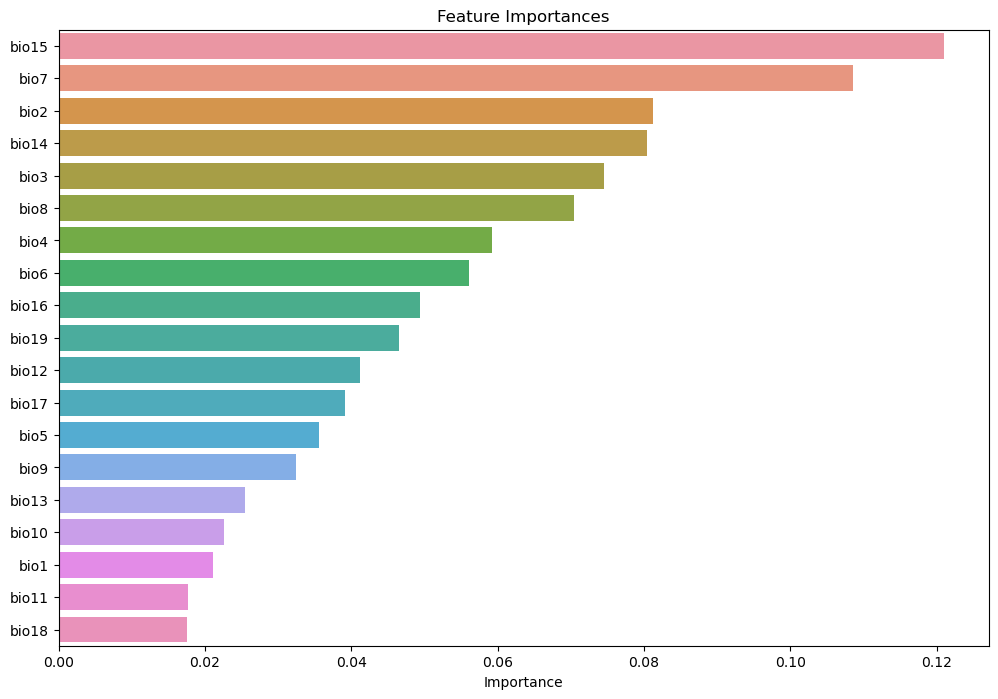

In [209]:
importance = forest.feature_importances_
# Assuming X_train has column names
feature_names = X.columns
feature_importance = pd.DataFrame(importance, index=feature_names, columns=["Importance"])

# Sort features by importance
feature_importance_sorted = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance_sorted)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y=feature_importance_sorted.index, data=feature_importance_sorted)
plt.title('Feature Importances')
plt.show()

In [190]:
#env_test['bio1'] = (env_test['bio1'] - mean_env) / std_env

In [193]:
y_predict.shape

(287, 13985)

In [194]:
from sklearn.metrics import r2_score

In [195]:
# Calculate R^2 for each SNP
r2_scores = r2_score(y, y_predict, multioutput='raw_values')
print("R^2 scores for each SNP:", r2_scores)

# Calculate overall R^2
overall_r2 = r2_score(y, y_predict)
print("Overall R^2:", overall_r2)

R^2 scores for each SNP: [0.11437454 0.24114825 0.11452518 ... 0.32078502 0.14595947 0.1216947 ]
Overall R^2: 0.18064479139890824


<Axes: ylabel='Count'>

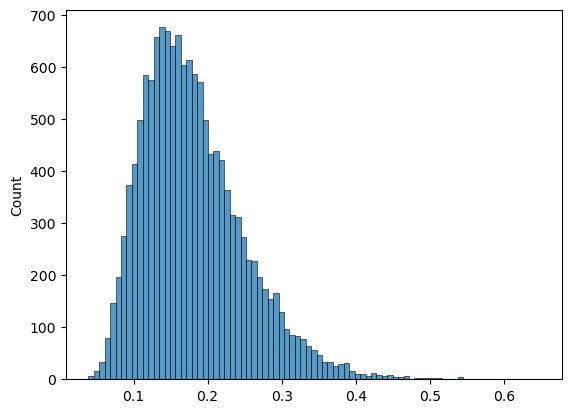

In [196]:
sns.histplot(pd.Series(r2_scores))

In [197]:
mask_rscores = r2_scores > 0.5

In [198]:
mask_rscores.shape

(13985,)

In [199]:
y_sign = y.iloc[:, mask_rscores]

In [200]:
# Create a random forest regressor object
forest = RandomForestRegressor(n_estimators=500, random_state=42)

# Train the model
forest.fit(X, y_sign)

RandomForestRegressor(n_estimators=500, random_state=42)

In [201]:
y_predict2 = forest.predict(X_test)

In [ ]:
## import deltap ld for testing because not ldp will take forever 
delta_ldp_test = pd.read_csv('/carnegie/nobackup/scratch/xwu/grenet/merged_frequency/merged_hapFIRE_delta_p_LDpruned.txt', 
                        sep = '\t', 
                        usecols = test_samples)

y_test = delta_ldp_test.T.copy()

In [204]:
y_test_sign = y_test.iloc[:, mask_rscores]

In [205]:
y_test_sign.shape

(68, 14)

In [206]:
y_predict2.shape

(68, 14)

In [207]:
# Calculate R^2 for each SNP
r2_scores = r2_score(y_test_sign, y_predict2, multioutput='raw_values')
print("R^2 scores for each SNP:", r2_scores)

# Calculate overall R^2
overall_r2 = r2_score(y_test_sign, y_predict2)
print("Overall R^2:", overall_r2)

R^2 scores for each SNP: [-0.72886606 -0.77411021  0.1185532  -0.11568484 -0.02089683  0.09842297
 -0.40803321 -0.36825204 -0.28102286 -0.52748132  0.02126079 -0.09475915
 -0.0760025   0.13646577]
Overall R^2: -0.21574330753176924


<Axes: ylabel='Count'>

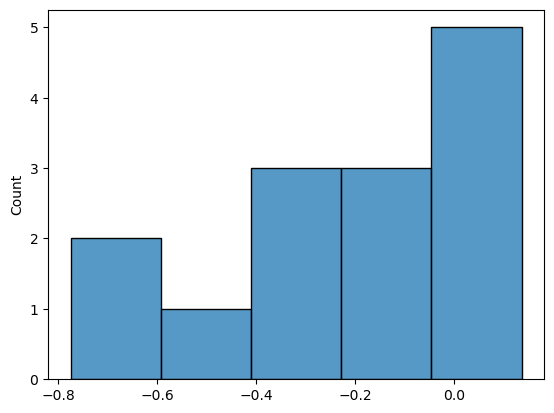

In [208]:
sns.histplot(pd.Series(r2_scores))

In [ ]:
# Make predictions
y_pred = forest.predict(X_test)

# Calculate MSE for each SNP
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("MSE for each SNP:", mse)

# Calculate overall MSE
overall_mse = mean_squared_error(y_test, y_pred)
print("Overall MSE:", overall_mse)